In [1]:
start_time = time()

pred_dict = real_time_forecast("../../data/raw/PLEINVREES_2022_AMSTERDAM/transactions.csv", "Amsterdam", "11:00", 200,\
                   "04/06/22", "18:00", ["Test", "Statiegeld", "Beker", "Earplugs"])
SAVE_PREDICTIONS_DICT = pred_dict
end_time = time()
print("--------------------------------------------------------------")
print(f"Run time in seconds: {(end_time-start_time)}")

NameError: name 'time' is not defined

At the moment terminal pomms 1.03 has an empty storage for product Verse Friet.

At the moment terminal pomms 1.02 has an empty storage for product Verse Friet.

Product Vegan Kapsalon will run out of storage at terminal pomms kapsalon 1.02 around 2022-06-04 19:25:00!

Product Raket will run out of storage at terminal ola 1.02 around 2022-06-04 19:20:00!

Product Raket will run out of storage at terminal ola 1.01 around 2022-06-04 19:15:00!

At the moment terminal pomms 1.03 has an empty storage for product Verse Friet.

At the moment terminal beyond meat 1.03 has an empty storage for product Beyond Burger.

At the moment terminal pomms kapsalon 1.02 has an empty storage for product Vegan Kapsalon.

At the moment terminal pomms 1.02 has an empty storage for product Verse Friet.

At the moment terminal ola 1.02 has an empty storage for product Raket.

At the moment terminal ola 1.01 has an empty storage for product Raket.

At the moment terminal ola 1.03 has an empty storage for product

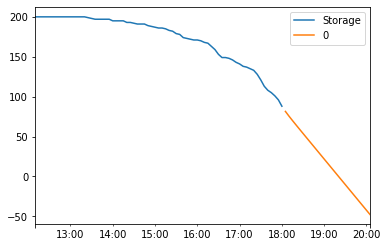

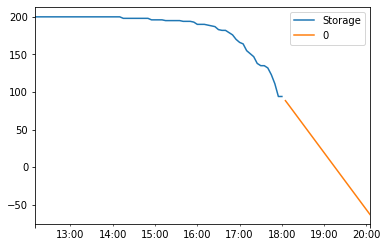

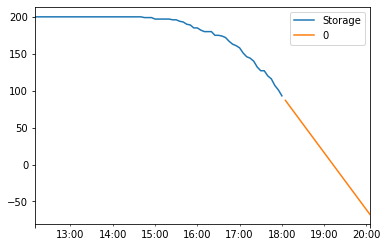

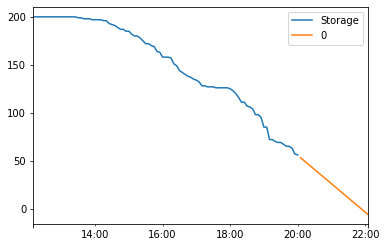

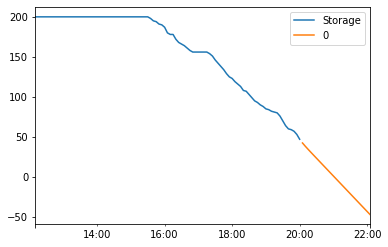

In [2]:
import numpy as np
import pandas as pd
from ast import literal_eval
from time import time
from statsmodels.tsa.arima.model import ARIMA
from geopy.geocoders import Nominatim
from datetime import timedelta, datetime
from meteostat import Point, Hourly
import warnings
warnings.filterwarnings("ignore")



def add_weather_columns(df: pd.DataFrame, city: str, time_column="time") -> pd.DataFrame:
    # get coordinates
    geolocator = Nominatim(user_agent="Turkey")
    location = geolocator.geocode(city)
    lat, lon = location.latitude, location.longitude
    location = Point(lat=lat, lon=lon)
    
    # get timespan
    df[time_column] = df[time_column].astype('datetime64')
    start = min(df[time_column]).to_pydatetime() - timedelta(hours=1)
    end = max(df[time_column]).to_pydatetime() + timedelta(hours=1)
    
    # get data
    data = Hourly(location, start, end)
    data = data.fetch()
    
    # merge dataframes
    new_cols = data.columns
    new_cols_prefix = ['weather_' + col for col in new_cols]
    times = pd.DataFrame(df[time_column].dt.round('H'))
    times = times.merge(data, left_on=time_column, right_on='time')
    
    df.reset_index(drop=True, inplace=True)
    times.reset_index(drop=True, inplace=True)
    df = pd.concat([df, times[new_cols]], axis=1)
    return df

def pre_processing_data(path: str, city: str) -> pd.DataFrame:
    df = pd.read_csv(path,
                         index_col='Unnamed: 0', 
                         dtype = {"tra_id": int, "vde_name": str},
                         parse_dates = ["tra_timestamp_report"])
    try:
        df.rename(columns = {'tra_timestamp_report':'time', 'vde_name':'terminal', 'prd_name_long': 'product', 'tra_id':'transaction id'}, inplace = True)
    except:
        raise ImportError("Make sure that the input data has atleast a \'tra_timestamp_report\', 'tra_id, \'vde_name\', and \'prd_name_long\' column.")
    
    # sort on date and add weather data
    df.sort_values(by='time', inplace=True)
    df = add_weather_columns(df, city)
    df = df[['time', 'transaction id','terminal','product']]
    
    return df

def retrieve_day_from_data(df: pd.DataFrame, starting_hour: str, custom_day:str=None, custom_hour:str=None) -> pd.DataFrame:
    
    # retrieve only the current day from data
    days_raw = df['time'].to_numpy()
    days = [datetime.fromisoformat(str(day).replace('T', ' ')[:19]) for day in days_raw]
    day_binary = []

    # no custom_day given
    if custom_day == None:
        current_day = datetime.today()
        end_event_day = datetime.today()
        a = current_day.replace(hour=0, minute=0, second=0, microsecond=0)
        b = current_day.replace(hour=5, minute=0, second=0, microsecond=0)

        # store the start and end time for the current event day
        try:
            start_event_day = current_day.replace(hour=int(starting_hour[:2]), 
                                                  minute=int(starting_hour[3:]), 
                                                  second=0, 
                                                  microsecond=0)
        except:
            raise SyntaxError("Wrong format for starting_hour, format: \"HH:MM\" ")

        # check if current_day is between 00:00 and 05:00
        if a < current_day < b:
            start_event_day = (start_event_day-timedelta(1, 0, 0))      
    else:
        if custom_hour == None:
            raise SyntaxError("You forgot to specify the custom_hour, format: \"HH:MM\" ") 
        try: 
            current_day = pd.to_datetime([custom_day], format="%d/%m/%y").to_pydatetime()[0] 
        except:
            raise SyntaxError("Wrong format for custom_day, format: \"%d/%m/%y\" ")
        try:
            start_event_day = current_day.replace(hour=int(starting_hour[:2]), 
                                                  minute=int(starting_hour[3:]), 
                                                  second=0, 
                                                  microsecond=0)
        except:
            raise SyntaxError("Wrong format for starting_hour, format: \"HH:MM\" ")

        end_event_day = current_day.replace(hour=int(custom_hour[:2]), 
                                            minute=int(custom_hour[3:]), 
                                            second=0, 
                                            microsecond=0)

    # use start_event_day to only retrieve data from the current day
    for day in days:
        if start_event_day <= day <= end_event_day:
            day_binary.append(1)
        else:
            day_binary.append(0)

    df["day_binary"] = day_binary
    df = df.loc[df["day_binary"] == 1]
    
    return df[df.columns[0:4]]


def df_transform(x):
    output_dict = {}
    amount_term_tuples = []
    
    prod_list = list(x["product"].items())
    terminal_list = list(x["terminal"].items())
    
    tuples = [(terminal_list[i][1], prod_list[i][1]) for i in range(len(terminal_list))]
    for terminal, prod_lst in tuples:
        prod_dict = {}
        if terminal in output_dict.keys():
            old_prod_dict = output_dict[terminal]
            for prod in prod_lst:
                if prod in prod_dict.keys():
                    val = prod_dict.get(prod)
                    prod_dict[prod] = val + 1
                elif prod in old_prod_dict.keys():
                    val = old_prod_dict.get(prod)
                    prod_dict[prod] = val + 1
                else:
                    prod_dict[prod] = 1
            output_dict[terminal] = prod_dict
        else:
            for prod in prod_lst:
                if prod in prod_dict.keys():
                    val = prod_dict.get(prod)
                    prod_dict[prod] = val + 1
                else:
                    prod_dict[prod] = 1
            output_dict[terminal] = prod_dict
    return output_dict
           
# function for making a new df for a product, for the corresponding terminal
def new_df(df: pd.DataFrame, terminal: str, product: str, start_storage: int, \
           length: int, df_per_prod_dict: dict, new_prod_set: set) -> (dict, set):
    new_index = df.iloc[:length].index
    storage_list = []
    for i in range(length):
        storage_list.append(start_storage)
    prod_df = pd.DataFrame(storage_list, index=new_index)
    prod_df.columns = ["Storage"]
    df_per_prod_dict[product] = prod_df
    new_prod_set.add(product)
    all_existing_df[terminal].add(product)
    
    return df_per_prod_dict, new_prod_set

# function for adding a new row with updated storage to the product df,
# for the corresponding terminal
def update_df(start_storage: int, current_time: pd.Timestamp, terminal: str, product: str, amount: int, \
              df_per_prod_dict: dict, new_prod_set: set, updated_prod_set: set) -> (dict, set):
    if product in new_prod_set:
        old_df = df_per_prod_dict[product]
    else:               
        temp_prod_df_dict = globals()[terminal]
        old_df = temp_prod_df_dict[product]
    old_storage = old_df.iloc[-1]
    new_storage = old_storage - amount
    temp_df = pd.DataFrame([new_storage], index=[current_time])
    temp_df.columns = ["Storage"]
    updated_df = pd.concat([old_df,temp_df])
    
    df_per_prod_dict[product] = updated_df
    updated_prod_set.add(product)
    
    return df_per_prod_dict, updated_prod_set

# function for extending the product df with a row with the same storage,
# for the corresponding terminal
def extend_df(current_time: pd.Timestamp, terminal: str, df_per_prod_dict: dict, todo_prod_set: set) -> dict:
    for todo_prod in todo_prod_set:
        temp_prod_df_dict = globals()[terminal]
        old_df = temp_prod_df_dict[todo_prod]
        old_storage = old_df.iloc[-1]
        temp_df = pd.DataFrame([old_storage], index=[current_time])
        temp_df.columns = ["Storage"]
        new_df = pd.concat([old_df,temp_df])
        df_per_prod_dict[todo_prod] = new_df
    
    return df_per_prod_dict

# function extending all product dfs with with a row with the same storage,
# for each terminal with no transaction this period
def extend_terms_no_trans(term_notran_set: set, current_time: pd.Timestamp):
    for term in term_notran_set:
        temp_prod_df_dict = globals()[term]
        df_per_prod_dict = dict()
        for prod, old_prod_df in temp_prod_df_dict.items():
            old_storage = old_prod_df.iloc[-1]
            temp_df = pd.DataFrame([old_storage], index=[current_time])
            temp_df.columns = ["Storage"]
            updated_df = pd.concat([old_prod_df,temp_df])
            df_per_prod_dict[prod] = updated_df
        globals()[term] = df_per_prod_dict
        
    return

def forecast(start_storage: int, terminal: str, product: str, out_of_storage: dict, \
             pred_dict: dict, already_empty_list: list) -> (dict, dict, list):
    train = globals()[terminal][product]
    start = len(train)
    
    # more than one hour is needed to make a prediction,
    # if there is less than three hours available make a one-hour-ahead prediction,
    # else make a two-hour-ahead prediction
    if start < 11:
        raise ValueError("The model needs at least an hour of data to make a prediction.")
    if start < 35:
        end = start + 12
    else: 
        end = start + 24
    last_storage = train.values[-1][0]
    
    # check if the current storage is negative
    if last_storage <= 0:
        already_empty_list.append((terminal, product))
        return out_of_storage, pred_dict, already_empty_list      
        
    
    # only make a prediction if there is less 50% of the start storage
    if last_storage < (0.5*start_storage):
        model = ARIMA(train,order=(1,2,1))
        model = model.fit()
        pred = model.predict(start=start,end=end,typ="levels")

        # look for negative storage in the predicted values
        for pred_time, pred_storage in pred.iteritems():
            if pred_storage <= 0.0 and ((terminal, product) not in out_of_storage.keys()):
                out_of_storage[(terminal, product)] = pred_time
                pred_dict[(terminal, product)] = pred
                return out_of_storage, pred_dict, already_empty_list
    return out_of_storage, pred_dict, already_empty_list

def df_to_term_prod_dfs(df: pd.DataFrame, start_storage: int):
    period_counter = 0
    for current_time, period_dict in list(df.items()):
        if period_counter == 0:
            prev_period_dict = period_dict
            period_counter += 1
            continue
            
        # for every terminal, product pair make or update the dataframe
        for terminal, product_dict in prev_period_dict.items():
            if terminal not in all_existing_df.keys():
                all_existing_df[terminal] = set()

            # variables to store information
            df_per_prod_dict = dict()
            updated_prod_set = set()
            new_prod_set = set()
            
            # for every product, with a transaction, create/update a dataframe 
            for product, amount in product_dict.items():
                # new products get a dataframe of length t-1 with the start_storage
                if product not in all_existing_df[terminal]:
                    df_per_prod_dict, new_prod_set = new_df(df, terminal, product, start_storage, \
                                                            period_counter, df_per_prod_dict, new_prod_set)
            
                # give all dataframes a new row with the updated storage
                df_per_prod_dict, updated_prod_set = update_df(start_storage, current_time, terminal, \
                                               product, amount, df_per_prod_dict, new_prod_set, updated_prod_set)
                
            # for every product, with no transaction, add new row with old storage
            todo_prod_set =  all_existing_df[terminal].difference(updated_prod_set)
            df_per_prod_dict = extend_df(current_time, terminal, df_per_prod_dict, todo_prod_set)
            
            # store the dict with a df per product in terminal variable
            globals()[terminal] = df_per_prod_dict
            
        # all products of all terminals, with no transaction, get a new row with old storage
        term_notran_set = set(all_existing_df.keys()).difference(set(prev_period_dict.keys()))
        extend_terms_no_trans(term_notran_set, current_time)
        
        prev_period_dict = period_dict
        period_counter += 1
        
    return

def real_time_forecast(path: str, city: str, starting_hour: str, start_storage:int, custom_day:str=None, \
                       custom_hour:str=None, filter_list:list=[]):
    # process data, and retrieve the current day
    processed_df = pre_processing_data(path, city)
    day_df = retrieve_day_from_data(processed_df, starting_hour, custom_day, custom_hour)

    # make time column the index column
    day_df.index = day_df["time"]
    day_df = day_df.drop("time",1)

    # filter out some products
    for filter_product in filter_list:
        day_df = day_df[day_df['product'] != filter_product]

    # group the same transactions
    trans_prod_df = day_df.groupby('transaction id')['product'].apply(np.array)
    day_df = day_df.drop("product",1)
    transactions_df = day_df.reset_index().merge(trans_prod_df, on='transaction id', how='left').set_index('time')

    # summarise the data s.t each row is a period of 5 minutes
    final_df = transactions_df[["terminal", "product"]].reset_index()\
        .groupby(pd.Grouper(key="time", freq="5min")).apply(df_transform)

    # convert final transactions data to a dataframe per product per terminal
    df_to_term_prod_dfs(final_df, start_storage)

    # make forecast
    out_of_storage = dict()
    pred_dict = dict()
    already_empty_list = list()
    for terminal, prod_set in all_existing_df.items():
        for prod in prod_set:
            out_of_storage, pred_dict, already_empty_list = forecast(start_storage, terminal, \
                                                                 prod, out_of_storage, pred_dict, already_empty_list)

    # print terminals that already have an emty storage for a product
    for (empty_term, empty_prod) in already_empty_list:
        print(f"At the moment terminal {empty_term} has an empty storage for product {empty_prod}.\n")

    # print the predicted out of storage products at a terminal
    for ((out_term, out_prod), empty_time) in out_of_storage.items():
        real_data = globals()[out_term][out_prod]
        plot_df = pd.concat([real_data,pred_dict[(out_term, out_prod)]])    
        print(f"Product {out_prod} will run out of storage at terminal {out_term} around {empty_time}!\n")
        plot_df.plot()
        
    return pred_dict

def test_real_time_forecast(path: str, city: str, starting_hour: str, start_storage:int, custom_day:str=None, \
                       custom_hour:str=None, filter_list:list=[]):
    # process data, and retrieve the current day
    processed_df = pre_processing_data(path, city)
    day_df = retrieve_day_from_data(processed_df, starting_hour, custom_day, "20:00")

    # make time column the index column
    day_df.index = day_df["time"]
    day_df = day_df.drop("time",1)

    # filter out some products
    for filter_product in filter_list:
        day_df = day_df[day_df['product'] != filter_product]

    # group the same transactions
    trans_prod_df = day_df.groupby('transaction id')['product'].apply(np.array)
    day_df = day_df.drop("product",1)
    transactions_df = day_df.reset_index().merge(trans_prod_df, on='transaction id', how='left').set_index('time')

    # summarise the data s.t each row is a period of 5 minutes
    final_df = transactions_df[["terminal", "product"]].reset_index()\
        .groupby(pd.Grouper(key="time", freq="5min")).apply(df_transform)

    # convert final transactions data to a dataframe per product per terminal
    df_to_term_prod_dfs(final_df, start_storage)

    # make forecast
    out_of_storage = dict()
    pred_dict = dict()
    already_empty_list = list()
    for terminal, prod_set in all_existing_df.items():
        for prod in prod_set:
            out_of_storage, pred_dict, already_empty_list = forecast(start_storage, terminal, \
                                                                 prod, out_of_storage, pred_dict, already_empty_list)

    # print terminals that already have an emty storage for a product
    for (empty_term, empty_prod) in already_empty_list:
        print(f"At the moment terminal {empty_term} has an empty storage for product {empty_prod}.\n")

    # print the predicted out of storage products at a terminal
    for ((out_term, out_prod), empty_time) in out_of_storage.items():
        real_data = globals()[out_term][out_prod]
        plot_df = pd.concat([real_data,pred_dict[(out_term, out_prod)]])    
        print(f"Product {out_prod} will run out of storage at terminal {out_term} around {empty_time}!\n")
        plot_df.plot()
        
    return pred_dict

########################################################################################


# global dict that stores each product that has an existing df, for each terminal
all_existing_df = dict()
pred_dict = real_time_forecast("../../data/raw/PLEINVREES_2022_AMSTERDAM/transactions.csv", "Amsterdam", "11:00", 200,\
                   "04/06/22", "18:00", ["Test", "Statiegeld", "Beker", "Earplugs"])
SAVE_PREDICTIONS_DICT = pred_dict

pred_raket_ola_101 = SAVE_PREDICTIONS_DICT[("ola 1.01","Raket")]
pred_raket_ola_101 = pd.DataFrame(pred_raket_ola_101)
pred_raket_ola_101.columns=["Storage"]
pred_raket_ola_102 = SAVE_PREDICTIONS_DICT[("ola 1.02","Raket")]
pred_raket_ola_102 = pd.DataFrame(pred_raket_ola_102)
pred_raket_ola_102.columns=["Storage"]
pred_pomms_102 = SAVE_PREDICTIONS_DICT[("pomms kapsalon 1.02","Vegan Kapsalon")]
pred_pomms_102 = pd.DataFrame(pred_pomms_102)
pred_pomms_102.columns=["Storage"]

for del_term in all_existing_df.keys():
    del globals()[del_term]

# global dict that stores each product that has an existing df, for each terminal
all_existing_df = dict()
pred_dict = real_time_forecast("../../data/raw/PLEINVREES_2022_AMSTERDAM/transactions.csv", "Amsterdam", "11:00", 200,\
                   "04/06/22", "20:00", ["Test", "Statiegeld", "Beker", "Earplugs"])

Real_raket_ola_101 = globals()["ola 1.01"]["Raket"].iloc[-24:]
Real_raket_ola_102 = globals()["ola 1.02"]["Raket"].iloc[-24:]
Real_pomms_102 = globals()["pomms kapsalon 1.02"]["Vegan Kapsalon"].iloc[-24:]


# Real_raket_ola_101.merge(pred_rak_ola_101, left_index=True,right_index=True)
err1 = np.mean(abs((Real_raket_ola_101 - pred_raket_ola_101).iloc[:-1]).values.flatten())
err2 = np.mean(abs((Real_raket_ola_102 - pred_raket_ola_102).iloc[:-1]).values.flatten())
err3 = np.mean(abs((Real_pomms_102 - pred_pomms_102).iloc[:-1]).values.flatten())

print( (err1+err2+err3) )

In [3]:
np.mean([1,2,3])

2.0

In [4]:
print( (err1+err2+err3)/3 )

17.442490920574567
